In [ ]:
!pip install gymnasium
!pip install gym-notices

In [1]:
import gymnasium as gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)
import copy
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
torch.manual_seed(0)

import base64, io

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob

device = torch.device("mps" if torch.backends.mps.is_available() else
                      "cuda:0" if torch.cuda.is_available() else
                      "cpu")
device = torch.device("cpu")    # actually faster than mps


### Algorithm: Twin Delayed Deep Deterministic Policy Gradients
Implementation based on the [original paper](https://arxiv.org/abs/1802.09477) and Open AI's [Spinning Up](https://spinningup.openai.com/en/latest/algorithms/td3.html#)

to try:
* OpenAI implementation has layer normalization in both actor and critic networks
* Notebook 3 implements the REINFORCE algorithm, where the selected action is sampled from the computed probabilities of picking each action
  * "Sampling process of discrete data from a categorical distribution is not differentiable, meaning that backpropagation wil not work. The Gumbel-Softmax distribution is a continuous distribution that approximates samples from a categorical distribution and also works with backpropagation" ([source](https://towardsdatascience.com/what-is-gumbel-softmax-7f6d9cdcb90e))
  * "the Gumbel-Softmax trick may remove the assumption of a deterministic policy for DDPG..."
  * Should the critic network get these probabilities as input ?
* Scheduler for the learning rate and/or the Gumbel-Softmax temperature
* (over-engineering) Wolpertinger policy architecture ([source](https://arxiv.org/abs/1512.07679))

In [7]:
"""
Utility functions for the Gumbel-Softmax trick

'During training, we let temperature > 0 to allow gradients past the sample, then gradually anneal the temperature (but not completely to 0, as the gradients would blow up)'
References:
-----------
https://blog.evjang.com/2016/11/tutorial-categorical-variational.html
https://github.com/shariqiqbal2810/maddpg-pytorch/blob/master/utils/misc.py
"""

def sample_gumbel(shape, eps=1e-20):
    """
    Sample from Gumbel(0,1)
    """
    U = torch.rand(shape, requires_grad=False)
    return -torch.log(-torch.log(U + eps) + eps)

def gumbel_softmax(logits, temperature=1.0, hard=False):
    """
    Sample from the Gumbel-Softmax distribution and optionally discretize.

    Parameters
    ----------
    logits: Tensor of shape (batch_size, n_class)
        Unnormalized log-probs.

    temperature: float
        Must be non-negative.

    hard: bool
        If True, take argmax but differentiate w.r.t soft sample y.

    Returns
    -------
    y: Tensor of shape (batch_size, n_class)
        Sample from the Gumbel-Softmax distribution.
        If hard=True, then the returned sample will be one-hot, otherwise it will be a probability distribution that sums to 1 across classes.
    """
    y = logits + sample_gumbel(logits.shape)
    y =  F.softmax(y/temperature, dim=1)
    if hard:
        y_hard = F.one_hot(torch.argmax(logits, dim=1), num_classes=logits.shape[1])
        y = (y_hard-y).detach() + y
    return y 


class ReplayBuffer(object):
    # max size ?
    def __init__(self, state_dim, action_dim):
        self.state_buffer = torch.empty((0, state_dim))
        self.action_buffer = torch.empty((0, action_dim))
        self.reward_buffer = torch.empty((0, 1), dtype=torch.float32)
        self.next_state_buffer = torch.empty((0, state_dim))
        self.done_buffer = torch.empty((0, 1), dtype=torch.int)

    def add_entry(self, state, action, reward, next_state, done):
        self.state_buffer = torch.cat(
            (self.state_buffer, torch.from_numpy(state).reshape(1,-1)),dim=0)
        self.action_buffer = torch.cat(
            (self.action_buffer, torch.tensor([action]).reshape(1,-1)), dim=0)
        self.reward_buffer = torch.cat(
            (self.reward_buffer, torch.tensor([reward], dtype=torch.float32).reshape(1,-1)), dim=0)
        self.next_state_buffer = torch.cat(
            (self.next_state_buffer, torch.from_numpy(next_state).reshape(1,-1)), dim=0)
        self.done_buffer = torch.cat(
            (self.done_buffer, torch.tensor([done], dtype=torch.int).reshape(1,-1)), dim=0)
    
    def sample(self, batch_size=1) -> dict:
        indices = torch.randint(0, self.state_buffer.shape[1], size=(batch_size,1)).squeeze()
        batch = (
            self.state_buffer[indices],
            self.action_buffer[indices],
            self.reward_buffer[indices],
            self.next_state_buffer[indices],
            self.done_buffer[indices]
            )
        return batch


class Actor(nn.Module):
    """
    Here, the action to be taken is computed as a real number that can be truncated for discrete scenarios.
    An alternative implementation for discrete problems might instead compute the probabilities of each action and pick the most probable one (see DiscreteActor class below)
    """
    def __init__(self, state_dim, action_dim, min_action, max_action, hidden_dim=256):
        super(Actor, self).__init__()

        self.l1 = nn.Linear(state_dim, hidden_dim)
        self.l2 = nn.Linear(hidden_dim, hidden_dim)
        self.l3 = nn.Linear(hidden_dim, action_dim)

        self.max_action = max_action
        self.min_action = min_action

    def forward(self, state):
        a = F.relu(self.l1(state))
        a = F.relu(self.l2(a))
        a = F.tanh(self.l3(a))
        return a
    
    def act(self, state, noise=0):
        action_range = self.max_action - self.min_action
        a = self.forward(state) + noise
        action = torch.clamp(
            a*action_range + self.min_action, min=self.min_action, max=self.max_action)
        return action


class DiscreteActor(nn.Module):
    """
    Computes the probability of picking each action, and select an action by sampling from the resulting distribution
    """
    def __init__(self, state_dim, n_actions, hidden_dim=256):
        super(DiscreteActor, self).__init__()

        self.l1 = nn.Linear(state_dim, hidden_dim)
        self.l2 = nn.Linear(hidden_dim, hidden_dim)
        self.l3 = nn.Linear(hidden_dim, n_actions)

        self.SpinningUp = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, n_actions)
        )

    def forward(self, state):
        probs = F.relu(self.l1(state))
        probs = F.relu(self.l2(probs))
        probs = F.tanh(self.l3(probs))
        #return probs
        return self.SpinningUp(state)   

    def act(self, state, noise=0):
        probs = F.softmax(self.forward(state) + noise, dim=-1)
        #action = Categorical(probs.cpu()).sample()
        action = torch.argmax(gumbel_softmax(probs, hard=True), dim=1)
        return action#.item()


class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(Critic, self).__init__()

        self.l1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.l2 = nn.Linear(hidden_dim, hidden_dim)
        self.l3 = nn.Linear(hidden_dim, action_dim)
        
        self.SpinningUp = nn.Sequential(
            nn.Linear(state_dim+action_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, action_dim)
        )

    def forward(self, state, action):
        state_action = torch.cat([state, action], dim=1)

        q = F.relu(self.l1(state_action))
        q = F.relu(self.l2(q))
        q = self.l3(q)
        #return q
        return self.SpinningUp(state_action)
    
"""
Hyperparameters
---------------           # [description]; values from      [original paper] / [spinning up]
"""
EXPL_NOISE = 0.1          # std of exploration noise;       0.1  / 0.1
TARGET_ACTION_NOISE = 0.2 # std of target policy noise;     0.2  / 0.2
NOISE_CLIP = 0.5          # clip target policy noise;       0.5  / 0.5
BATCH_SIZE = 256          # for off policy updates;         256  / 128
DISCOUNT = 0.98           # discount factor;                0.99 / 0.99
TAU = 0.005               # target network update rate;     5e-3 / 5e-3
START_TIME = 1e4          # pure exploration steps;         1e3  / 1e4
POLICY_UPDATE_PERIOD = 2  # steps between delayed updates;  2    / 2
HIDDEN_DIM = 32           # of actor and critic networks;   256  / 32 
LEARNING_RATE = 1e-3      # of actor and critic networks;   3e-4 / 1e-3

"""
Algorithm
---------
Twin Delayed Deep Deterministic Policy Gradients
"""
def train_TD3(env, max_t=int(1e6), n_episodes=2000):    # 1e6 timesteps in official implementation

    # all classical control envs have continuous states
    state_dim = env.observation_space.shape[0]

    # check if action space is discrete
    discrete_actions = isinstance(env.action_space, gym.spaces.Discrete)
    if discrete_actions:
        action_dim = 1
        min_action = 0
        max_action = env.action_space.n - 1
        actor = DiscreteActor(state_dim, max_action+1, HIDDEN_DIM).to(device)

    else:   # continuous action space
        action_dim = env.action_space.shape[0]
        assert env.action_space.low.shape == (1,), 'env has action_dim > 1'
        min_action = env.action_space.low[0]
        max_action = env.action_space.high[0]
        actor = Actor(state_dim, action_dim, min_action, max_action, HIDDEN_DIM).to(device)

    target_actor = copy.deepcopy(actor).to(device)
    actor_optimizer = torch.optim.Adam(actor.parameters(), lr=LEARNING_RATE)

    critic_1 = Critic(state_dim, action_dim, HIDDEN_DIM).to(device)
    critic_2 = Critic(state_dim, action_dim, HIDDEN_DIM).to(device)
    target_critic_1 = copy.deepcopy(critic_1).to(device)
    target_critic_2 = copy.deepcopy(critic_2).to(device)
    critic_optimizer = torch.optim.Adam(
        list(critic_1.parameters()) + list(critic_2.parameters()),
        lr=LEARNING_RATE)

    replay_buffer = ReplayBuffer(state_dim, action_dim)

    episode = 1
    episodes_reward = []    # reward of each episodes
    episode_reward = 0      # reward of the current episode

    # for debug purposes
    critic_losses = []
    actor_losses = []

    state = env.reset()[0]
    
    progress_bar = tqdm(total=n_episodes)
    for step in range(max_t):
        with torch.no_grad():
            if step < START_TIME:
                # Start by exploration
                action = env.action_space.sample()  # outputs (1,) array in continuous envs
            else:
                # Select action with noise
                noise = torch.normal(
                    mean=0.0, std=EXPL_NOISE, size=(1,action_dim)
                    ).to(device)
                action = actor.act(
                    torch.from_numpy(state).squeeze().to(device), noise)
                if discrete_actions:    # Gymnasium expects a single value in this case
                    action = action.item()
                else:                   # and a (1,) array in continous envs
                    action = action.flatten()
                    
            # Execute action and observe
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward

            # for discrete/continuous compatibility purposes
            if not discrete_actions:
                action = action.item()

            # Store tuple in replay buffer
            replay_buffer.add_entry(state, action, reward, next_state, done)

            # If s' is terminal, reset environment
            if done:
                state = env.reset()[0]
                episode += 1
                progress_bar.update(1)
                episodes_reward.append(episode_reward)
                episode_reward = 0
                if episode >= n_episodes:
                    break

            else:
                state = next_state

        # Training 
        if step > START_TIME:
            replay_state, replay_action, replay_reward, replay_next_state, replay_done = replay_buffer.sample(BATCH_SIZE)
            
            with torch.no_grad():   # no autograd for target networks
                # Select action with noise
                noise = (torch.normal(
                    mean=0.0, std=TARGET_ACTION_NOISE, size=(BATCH_SIZE, action_dim))
                    .clamp(-NOISE_CLIP, NOISE_CLIP)
                    ).to(device)
                # pretty sure it is replay_state in the paper pseudocode 
                target_action = target_actor.act(replay_next_state, noise).reshape(-1,1)

                # Compute target Q values
                target_Q1 = target_critic_1(replay_next_state, target_action)
                target_Q2 = target_critic_2(replay_next_state, target_action)
                target_Q = torch.minimum(target_Q1, target_Q2)
                y = replay_reward + DISCOUNT*(1-replay_done)*target_Q

            # Compute critic loss (gradient descent)
            Q1 = critic_1(replay_state, replay_action)
            Q2 = critic_2(replay_state, replay_action)
            critic_loss = F.mse_loss(Q1, y) + F.mse_loss(Q2, y)

            # Update critics
            critic_optimizer.zero_grad()
            critic_loss.backward()
            critic_optimizer.step()
            critic_losses.append(critic_loss.item())

            # Delayed policy updates (every d step)
            if (step % POLICY_UPDATE_PERIOD) == 0:
                # Gradient ascent
                actor_loss = -critic_1(replay_state, actor.act(replay_state).reshape(-1,1)).mean()

                # Update actor
                actor_optimizer.zero_grad()
                actor_loss.backward()
                actor_optimizer.step()
                actor_losses.append(actor_loss.item())

                # Update target networks
                for param, target_param in zip(critic_1.parameters(), target_critic_1.parameters()):
                    target_param.data.copy_(TAU*param.data + (1-TAU)*target_param.data)

                for param, target_param in zip(critic_2.parameters(), target_critic_2.parameters()):
                    target_param.data.copy_(TAU*param.data + (1-TAU)*target_param.data)

                for param, target_param in zip(actor.parameters(), target_actor.parameters()):
                    target_param.data.copy_(TAU*param.data + (1-TAU)*target_param.data)

    cumulative_rewards_t = np.cumsum(replay_buffer.reward_buffer)    
    return cumulative_rewards_t, episodes_reward, critic_losses, actor_losses

"""
Testing
-------
"""
envs = ["Acrobot-v1", "CartPole-v1", "MountainCarContinuous-v0", "MountainCar-v0", "Pendulum-v1"]
results = {}
for env_name in envs[-1:]:
    print(env_name)

    env = gym.make(env_name)
    env.reset(seed=0)

    torch.manual_seed(0)

    rewards_t, episodes_reward, critic_losses, actor_losses = train_TD3(env, n_episodes=500)
    results[env_name] = (rewards_t, episodes_reward, critic_losses, actor_losses)


Pendulum-v1


100%|█████████▉| 499/500 [03:16<00:00,  2.55it/s]


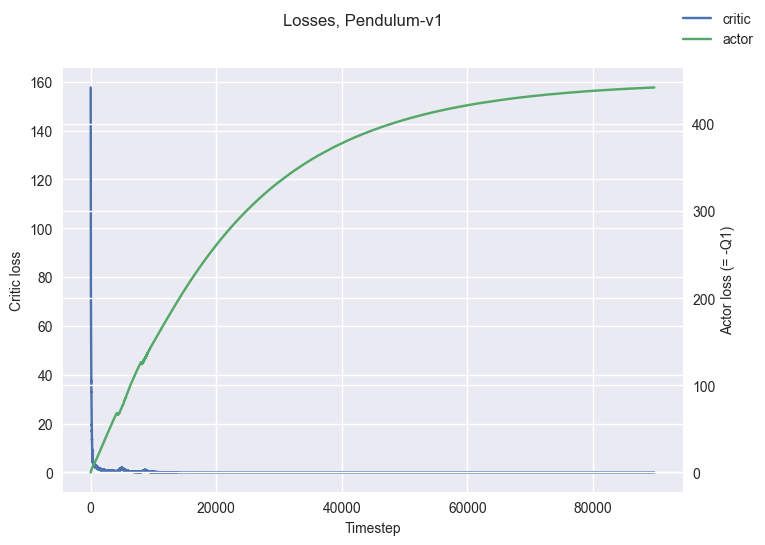

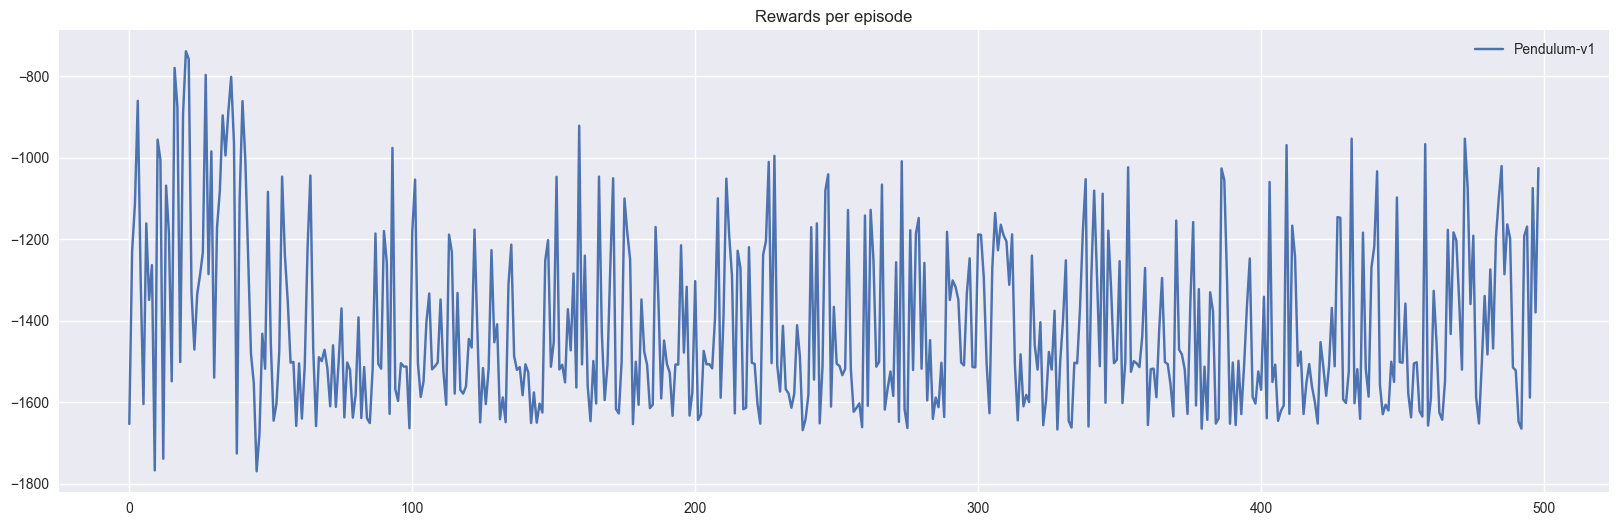

In [8]:
#fig, ax = plt.subplots(1,1, figsize=(20,6))
plt.style.use('seaborn-v0_8')
for env_name in results.keys():
    rewards_t, episodes_reward, critic_losses, actor_losses = results[env_name]
    
    actor_losses = np.repeat(actor_losses, POLICY_UPDATE_PERIOD)

    fig, ax1 = plt.subplots()
    critic_plot = ax1.plot(critic_losses, label='critic', color='C0')
    ax1.set_xlabel('Timestep')
    ax1.set_ylabel('Critic loss')
    ax2 = ax1.twinx()
    actor_plot = ax2.plot(actor_losses, label='actor', color='C1')
    ax2.set_ylabel('Actor loss (= -Q1)')
    fig.legend()
    fig.suptitle(f"Losses, {env_name}")
    plt.show()

    """
    plt.figure(figsize=(8,4))
    plt.plot(rewards_t, label=env_name)
    plt.legend()
    plt.title("Rewards over time")
    plt.show()
    """

    plt.figure(figsize=(20,6))
    plt.plot(episodes_reward,label=env_name)
    plt.title("Rewards per episode")
    plt.legend()
    plt.show()
    